In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 18.8 MB/s eta 0:00:00


In [3]:
pip install xgboost

In [4]:
pip install lightgbm

Importing Libraries

In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import optuna
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

Data Loading

In [11]:
train = pd.read_csv("/train.csv")

test = pd.read_csv("/test.csv")

sample_sub = pd.read_csv("/sample_submission.csv")

Data Exploration and Preprocessing

In [12]:
print("train dimension is : ",train.shape)
print("test dimension is :",test.shape)

train dimension is :  (20758, 18)
test dimension is : (13840, 17)


In [13]:
# Check for missing values
print("Missing Values in Each Column:\n", train.isnull().sum())

Missing Values in Each Column:
 id                                0
Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


Data Visualization and Feature Engineering

In [14]:
target ='NObeyesdad'


In [15]:
train.head()


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [16]:
#Removes the 'id' column
train.drop('id',axis=1,inplace=True)


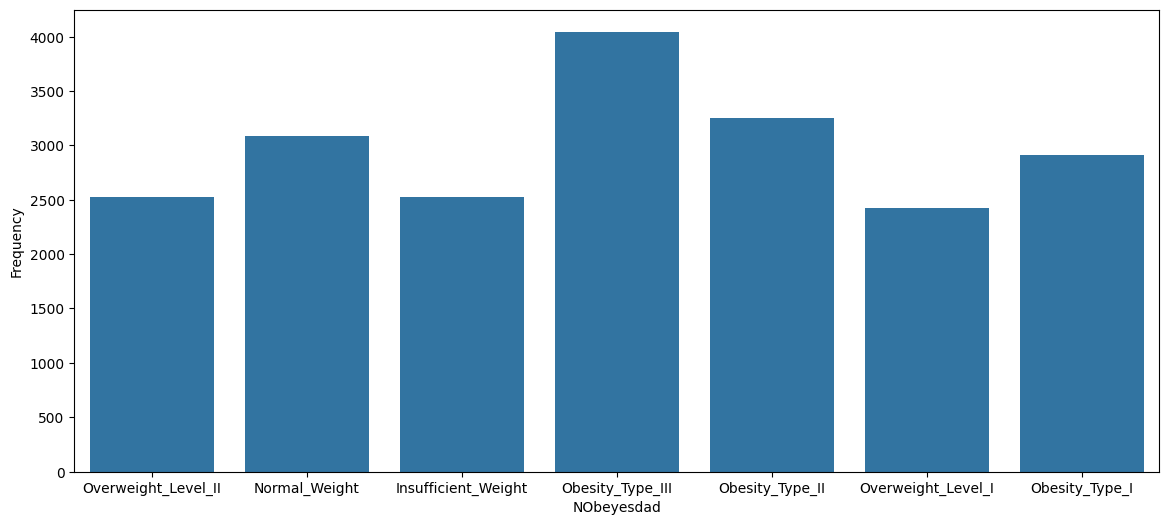

In [17]:
#visualize the distribution of the target variable 'NObeyesdad'.
plt.figure(figsize=(14, 6))
sns.countplot(data = train, x = 'NObeyesdad')
plt.ylabel('Frequency');

In [18]:
#Displays the data types of each column in the training dataset.
train.dtypes


,0
Gender,object
Age,float64
Height,float64
Weight,float64
family_history_with_overweight,object
FAVC,object
FCVC,float64
NCP,float64
CAEC,object
SMOKE,object


In [19]:
#Identifies and stores the names of categorical features
categorical_feats = []

for column in train.columns :
    if train[column].dtype == 'object':
        categorical_feats.append(column)

print(categorical_feats)

['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']


In [20]:
#Identifies and stores the names of numerical features
numerical_feats = []

for column in train.columns :
    if train[column].dtype != 'object':
        numerical_feats.append(column)

print(numerical_feats)

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


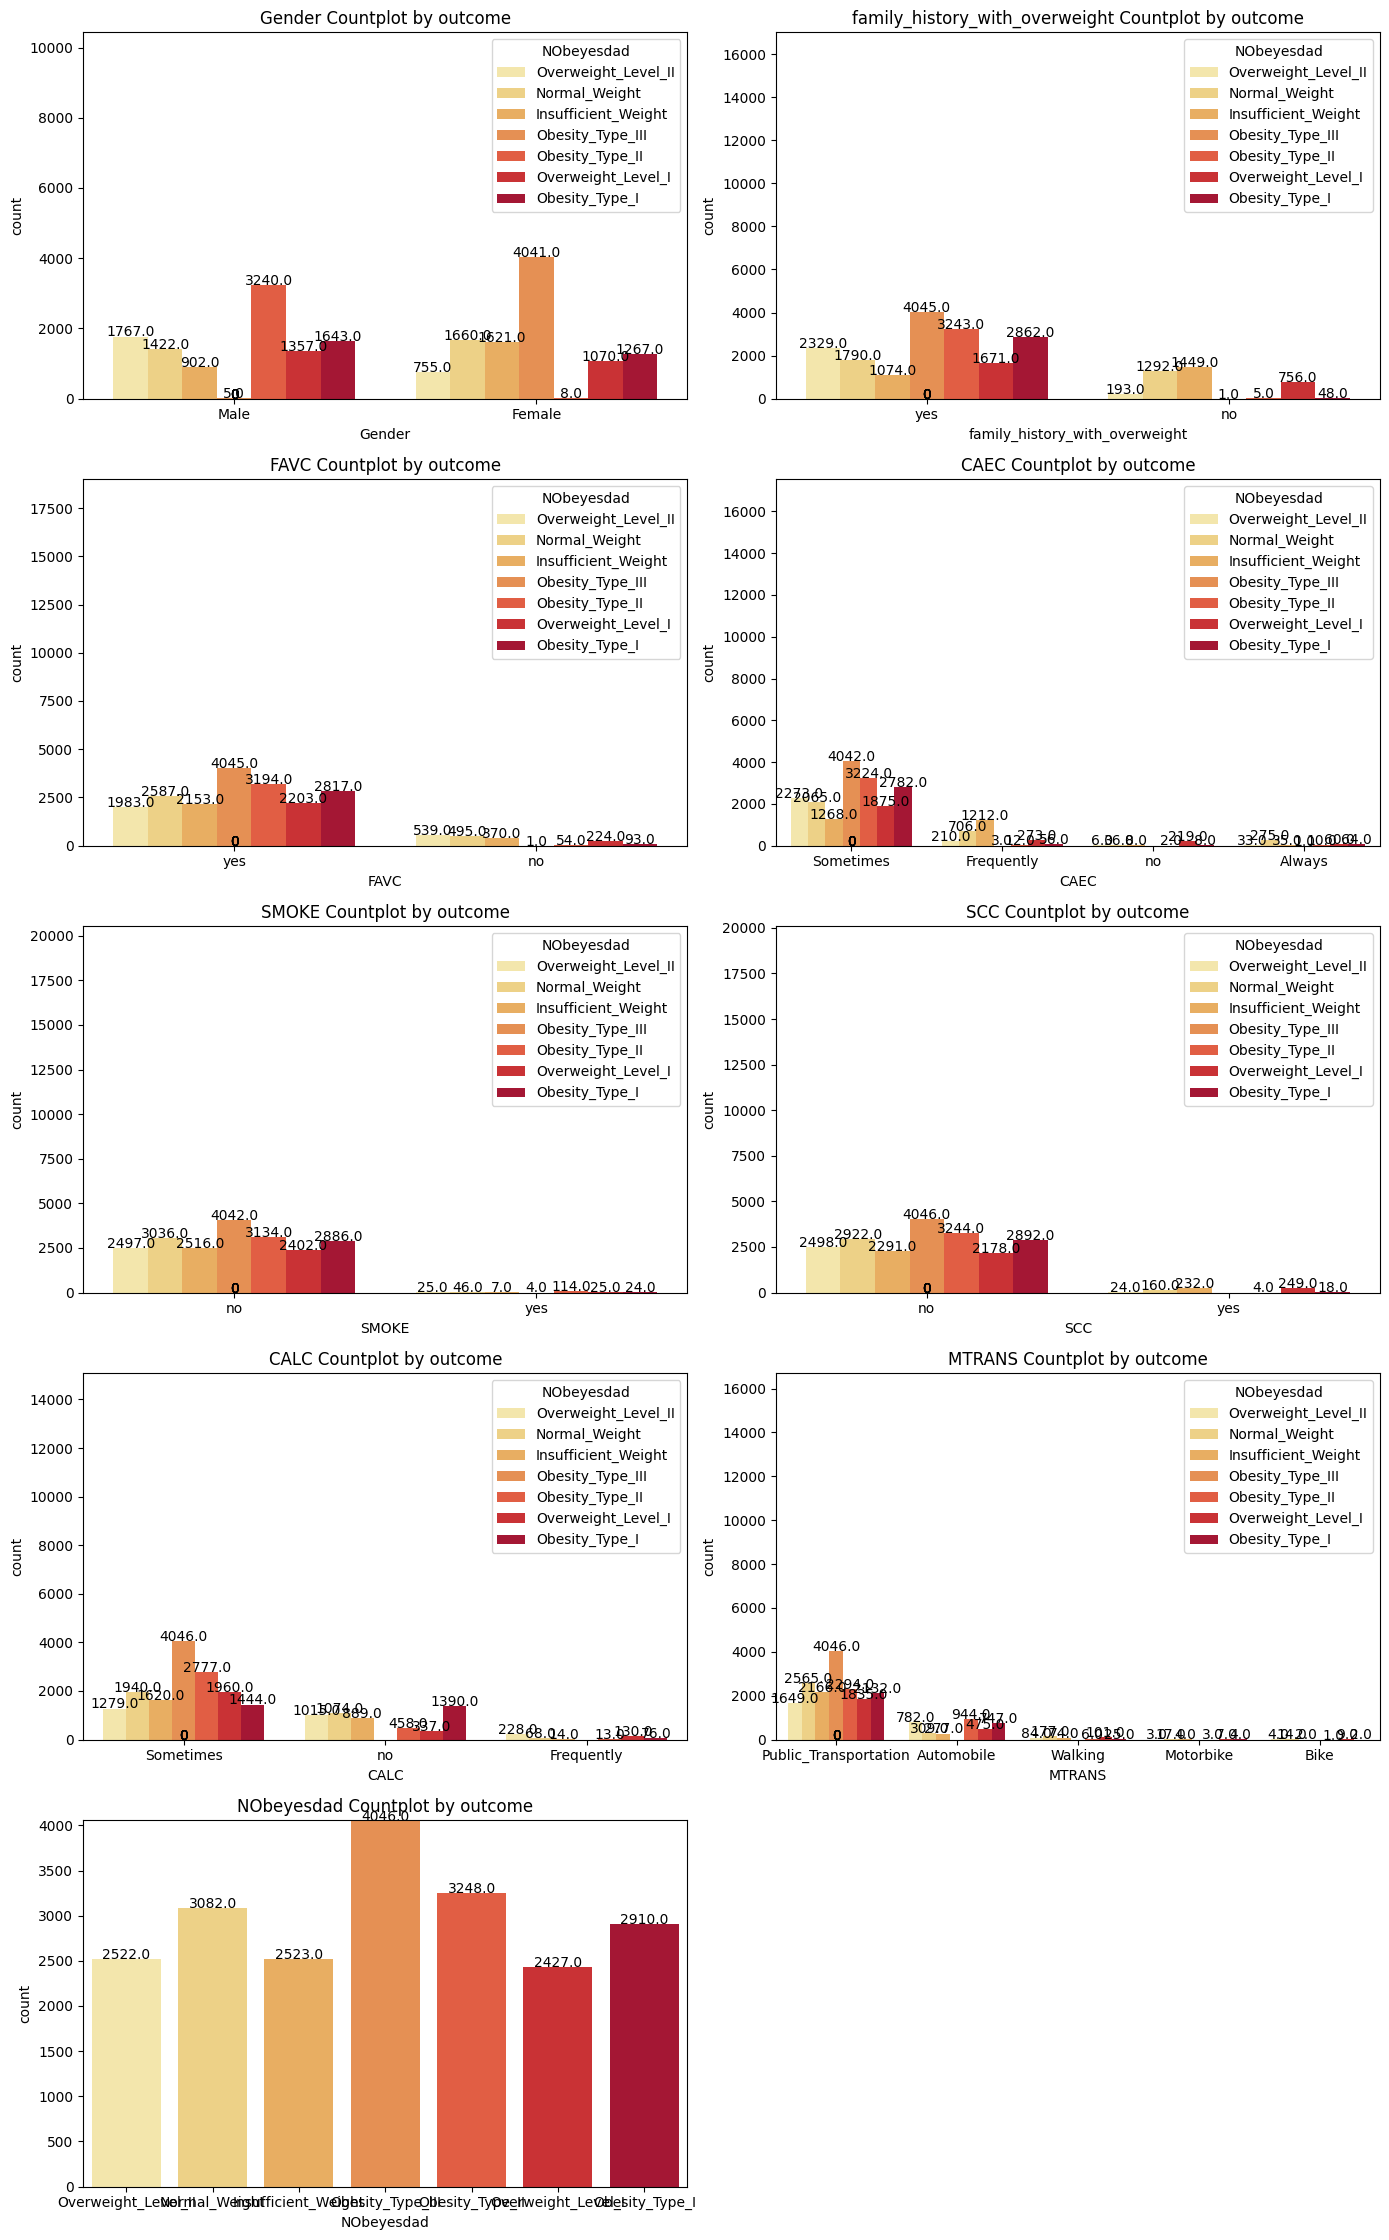

In [21]:
#visualize the relationship between each categorical feature and the target variable
plt.figure(figsize=(14, len(categorical_feats)*2.5))

for idx, column in enumerate(categorical_feats):
    plt.subplot(len(categorical_feats)//2 + len(categorical_feats) % 2, 2, idx+1)
    ax = sns.countplot(x=column, data=train, hue='NObeyesdad', palette='YlOrRd')
    plt.title(f"{column} Countplot by outcome")
    plt.ylim(0, train[column].value_counts().max() + 10)

    #This loop iterates through each bar
    for p in ax.patches:
        height = p.get_height()
        plt.text(p.get_x() + p.get_width()/2., height + 2, height, ha="center")



plt.tight_layout() #Adjusting the space between subplots
plt.show()

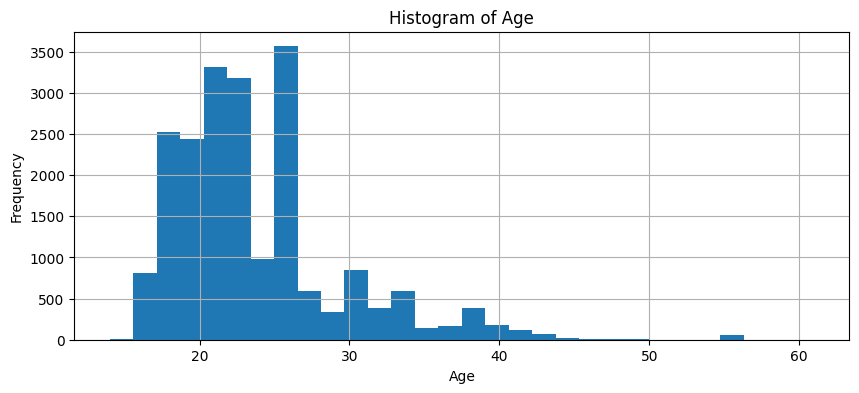

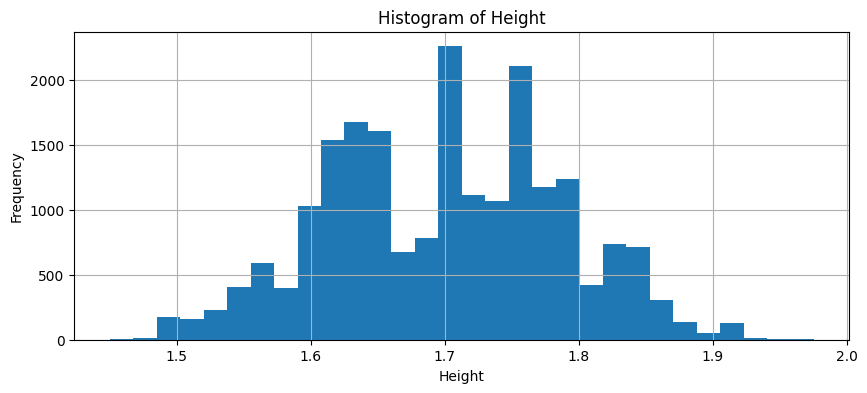

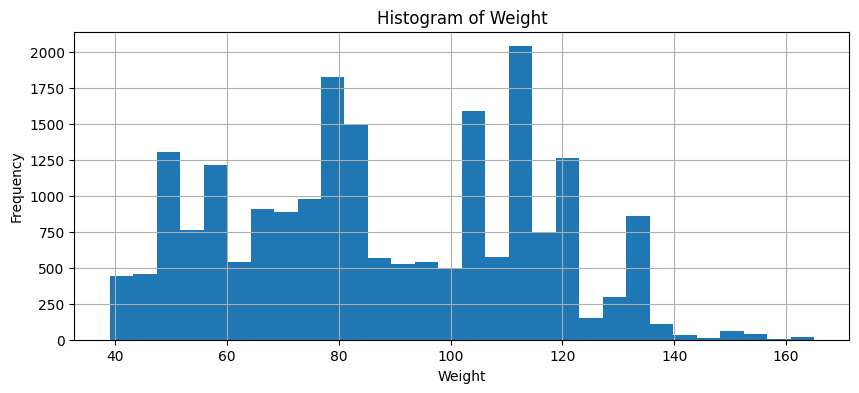

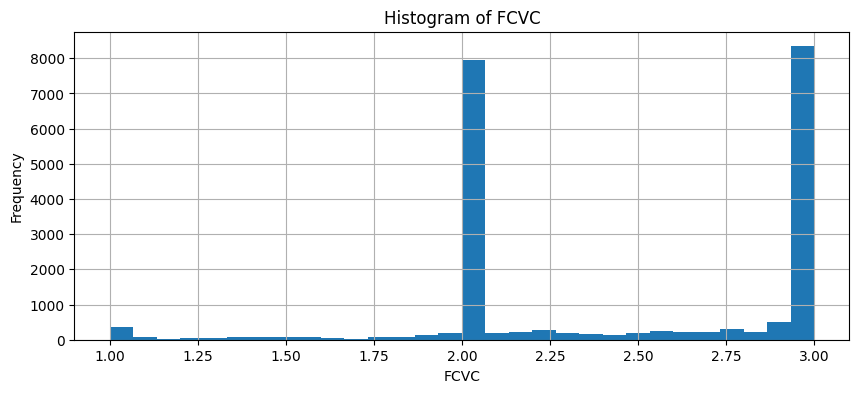

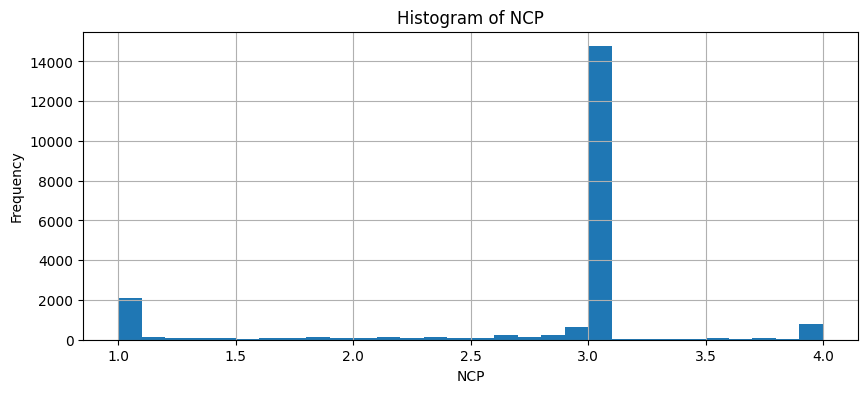

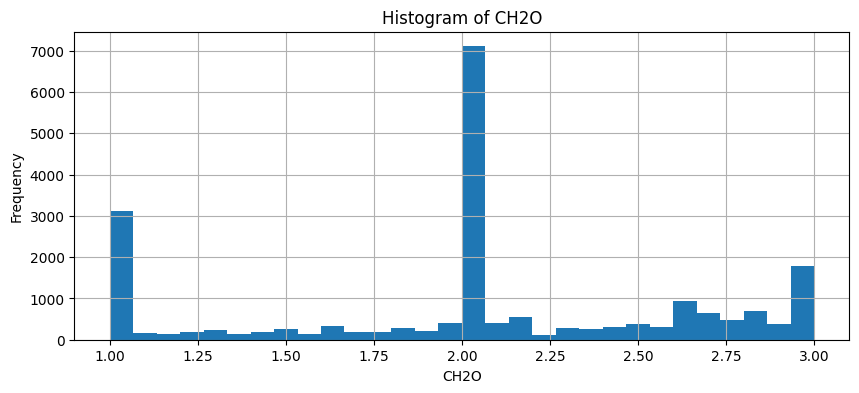

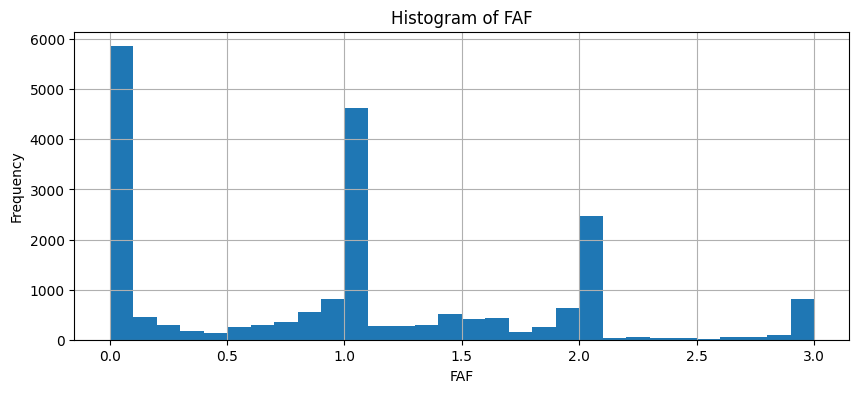

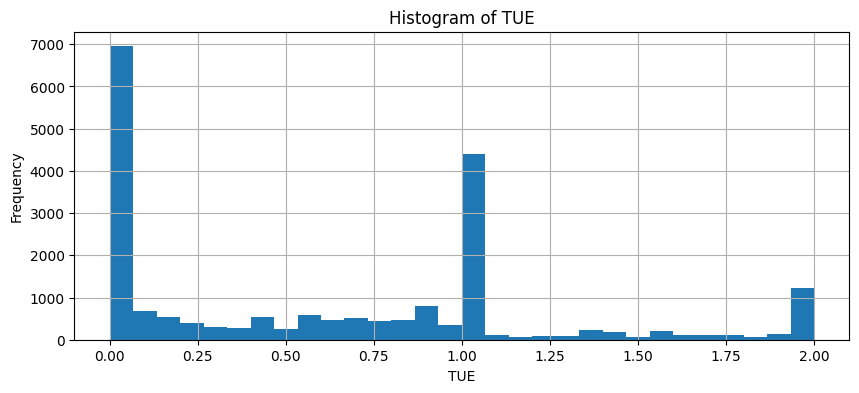

In [22]:
#Visualize the numerical feature distributions
for feature in numerical_feats:
    plt.figure(figsize=(10, 4))
    train[feature].hist(bins=30)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {feature}')
    plt.show()

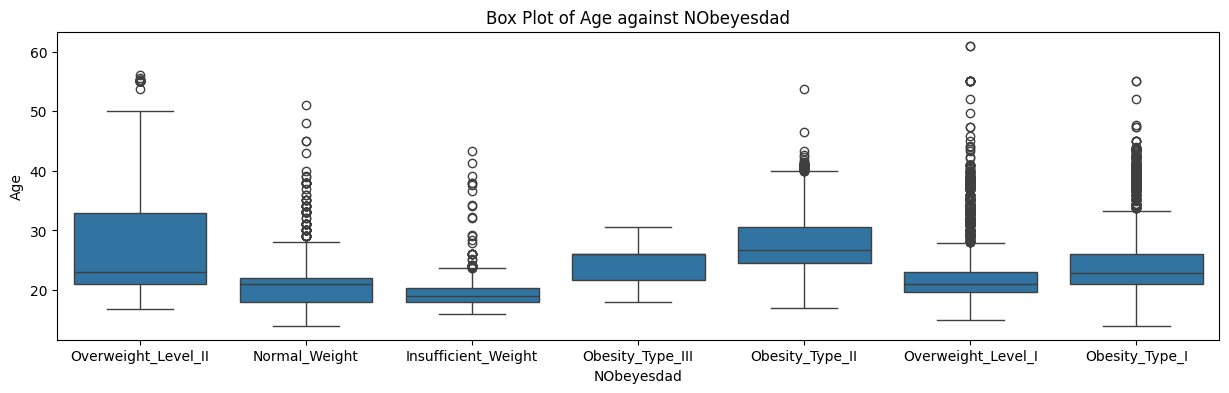

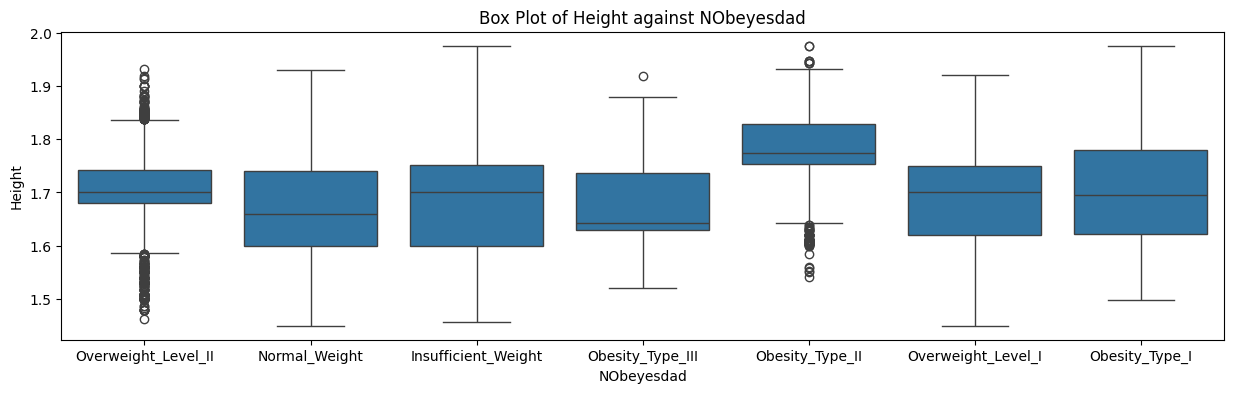

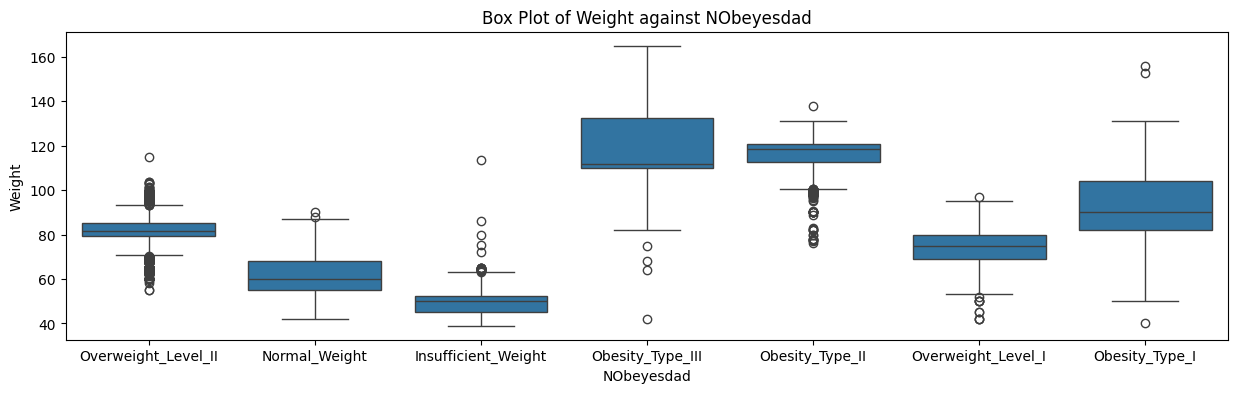

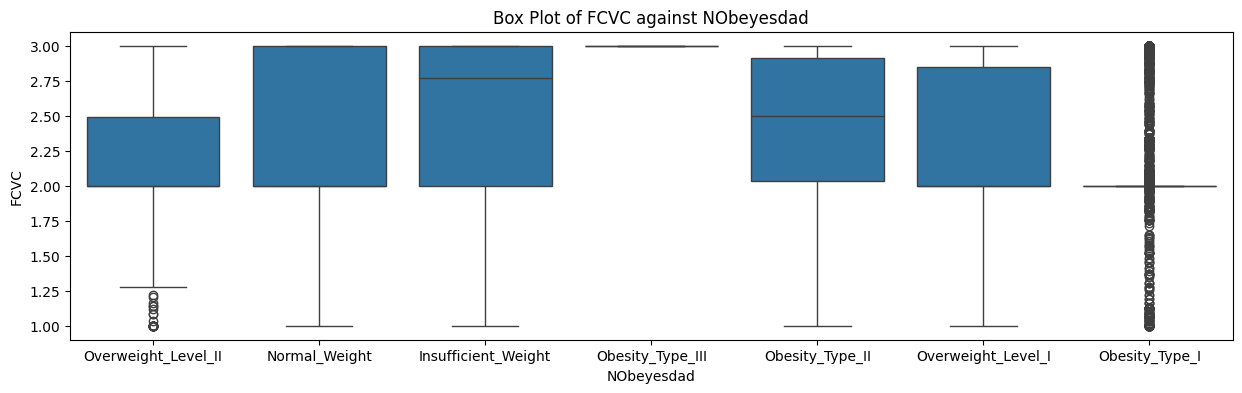

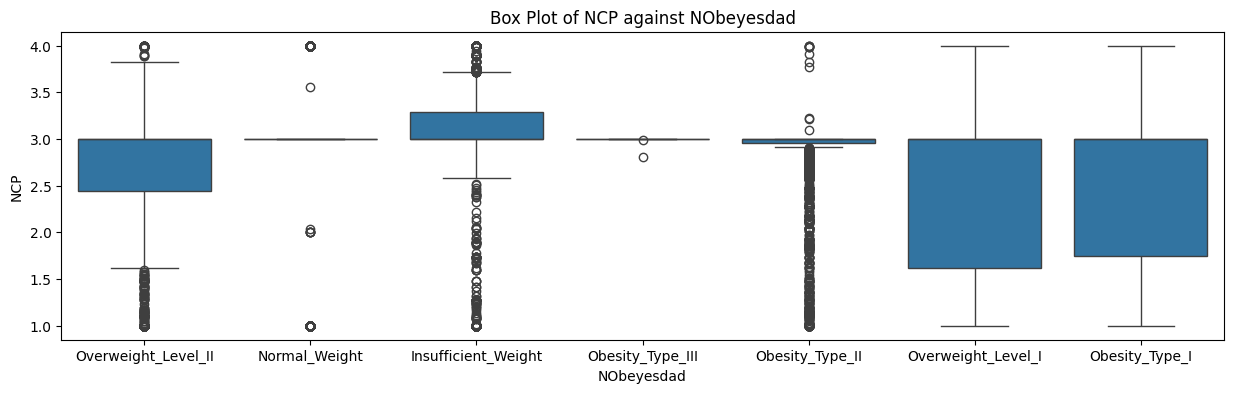

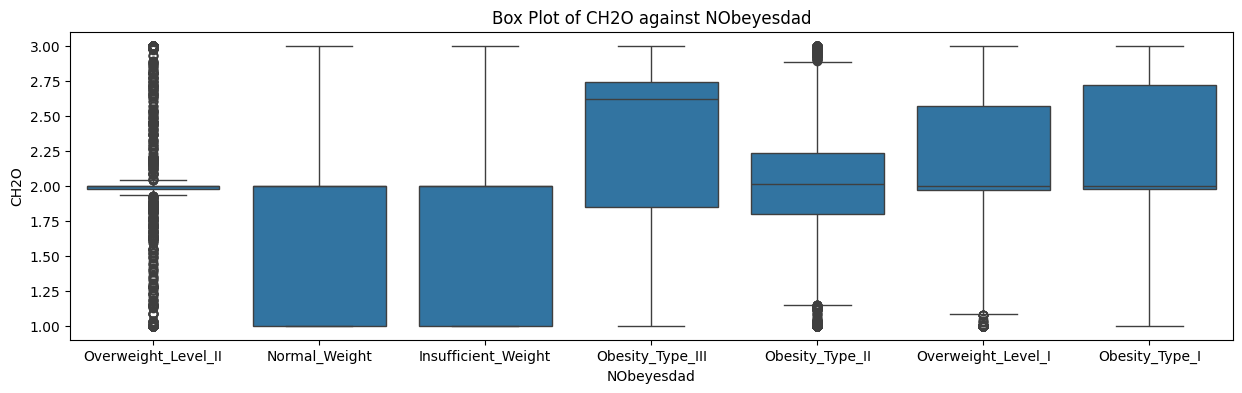

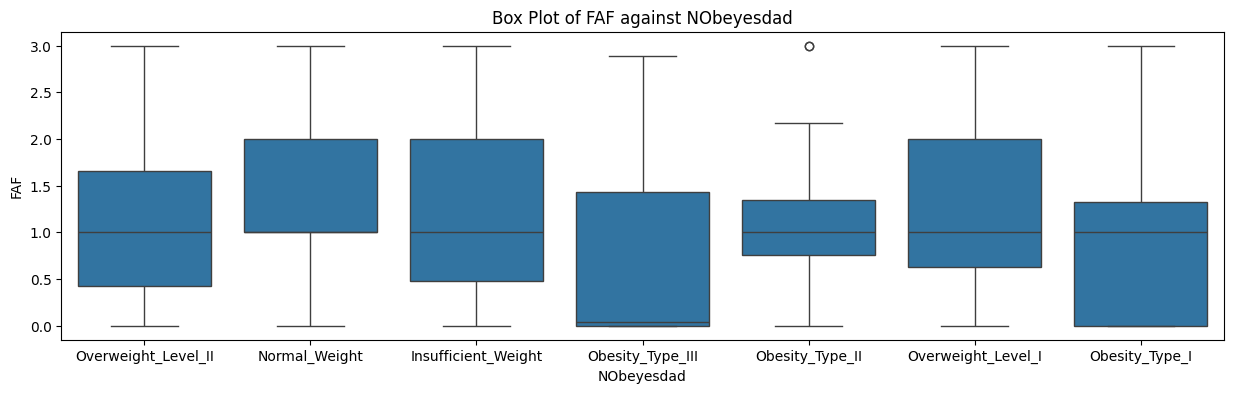

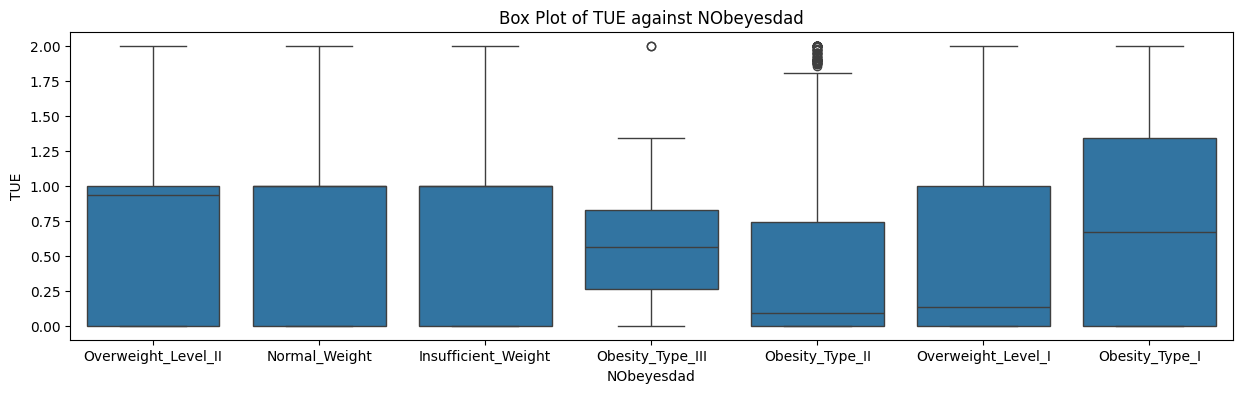

In [23]:
#box plots for each numerical feature, grouped by the target variable , to visualize the relationship between them.
for feature in numerical_feats:
    plt.figure(figsize=(15, 4))
    sns.boxplot(x=target, y=feature, data=train)
    plt.title(f'Box Plot of {feature} against {target}')
    plt.show()

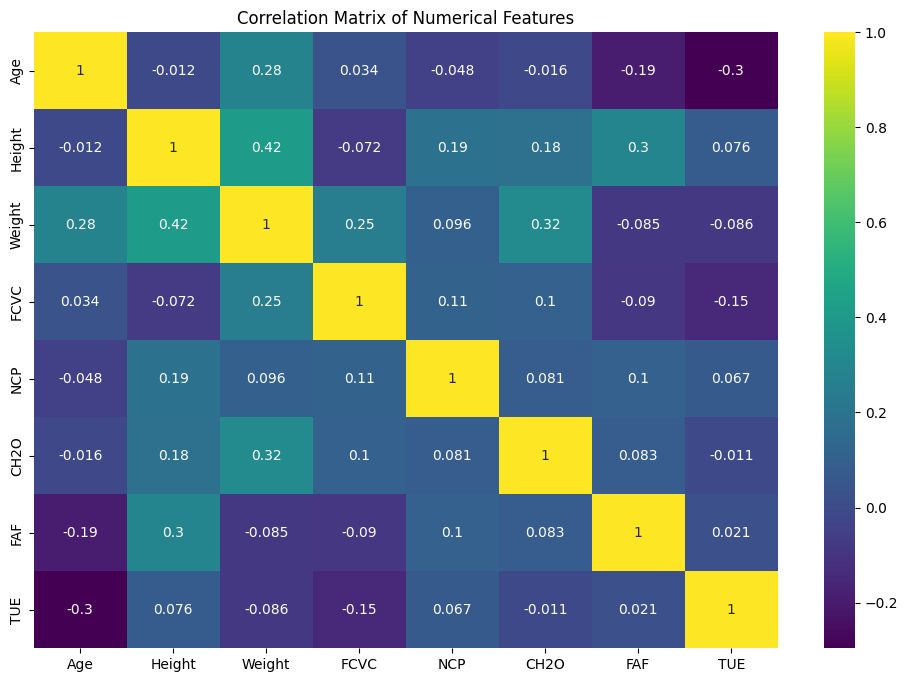

In [24]:
#calculates the correlation matrix for the numerical features and then visualizes it as a heatmap.
corr_matrix = train[numerical_feats].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [25]:
#Calculates the BMI for each person and categorize them based on BMI values
def bmi_category(row):
    bmi = row['Weight'] / (row['Height'] ** 2)

    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Healthy weight"
    elif 25 <= bmi < 30:
        return "Overweight"
    elif 30 <= bmi < 35:
        return "Obesity (Class 1)"
    elif 35 <= bmi < 40:
        return "Obesity (Class 2)"
    else:
        return "Obesity (Class 3)"

#The BMI category is stored in a new column called 'bmi_category' within the train,test DataFrames.
train['bmi_category'] = train.apply(bmi_category, axis=1)
test['bmi_category'] = test.apply(bmi_category, axis=1)

In [26]:
train['bmi_category'].head(10)


,bmi_category
0,Overweight
1,Healthy weight
2,Underweight
3,Obesity (Class 3)
4,Overweight
5,Underweight
6,Obesity (Class 2)
7,Obesity (Class 2)
8,Healthy weight
9,Obesity (Class 3)


In [27]:
#Label encoding
bmi_mapping = {
    "Underweight": 0,
    "Healthy weight": 1,
    "Overweight": 2,
    "Obesity (Class 1)": 3,
    "Obesity (Class 2)": 4,
    "Obesity (Class 3)": 5
}

#creates a new column called 'bmi_category_encoded'
train['bmi_category_encoded'] = train['bmi_category'].map(bmi_mapping)
test['bmi_category_encoded'] = test['bmi_category'].map(bmi_mapping)

#removes the original 'bmi_category' column
train = train.drop(columns='bmi_category')
test = test.drop(columns='bmi_category')

In [28]:
train['bmi_category_encoded'].head(10)


,bmi_category_encoded
0,2
1,1
2,0
3,5
4,2
5,0
6,4
7,4
8,1
9,5


In [29]:
#creates a new feature called 'age_faf' by multiplying the 'Age' and 'FAF
train['age_faf'] = train['Age'] * train['FAF']
test['age_faf'] = test['Age'] * test['FAF']

In [30]:
def calculate_lifestyle_score(row):
    favc_score = 0 if row['FAVC'] == 'No' else 1
    fcvc_score = row['FCVC']
    faf_score = row['FAF']
    tue_score = 1 if row['TUE'] > 2 else 0
    return favc_score - fcvc_score + tue_score - faf_score

#creates a new column called 'lifestyle_score'(defines overall healthiness of lifestyle)
train['lifestyle_score'] = train.apply(calculate_lifestyle_score, axis=1)
test['lifestyle_score'] = test.apply(calculate_lifestyle_score, axis=1)

In [31]:
def calculate_health_awareness_score(row):
    scc_score = 0 if row['SCC'] == 'No' else 1
    ch2o_score = row['CH2O']
    smoke_score = 1 if row['SMOKE'] == 'yes' else 0
    return scc_score + ch2o_score + smoke_score


train['health_awareness_score'] = train.apply(calculate_health_awareness_score, axis=1)
test['health_awareness_score'] = test.apply(calculate_health_awareness_score, axis=1)

In [32]:
train['NObeyesdad'].values


array(['Overweight_Level_II', 'Normal_Weight', 'Insufficient_Weight', ...,
       'Obesity_Type_II', 'Overweight_Level_II', 'Obesity_Type_II'],
      dtype=object)

In [33]:
#label encoding on the target variable 'NObeyesdad', converting the categorical obesity levels into numerical representations
y_train = train["NObeyesdad"].map({'Normal_Weight':0,'Insufficient_Weight':1,'Overweight_Level_I':2 ,'Overweight_Level_II':3,'Obesity_Type_I':4 ,'Obesity_Type_II':5
                                  ,'Obesity_Type_III':6})

In [34]:
#Remove target
categorical_feats.remove('NObeyesdad')


In [35]:
numerical_featstrain = []

for column in train.columns :
    if train[column].dtype != 'object':
        numerical_featstrain.append(column)

print(numerical_featstrain)

['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'bmi_category_encoded', 'age_faf', 'lifestyle_score', 'health_awareness_score']


In [36]:
#Label Encoding
train['Gender'] = train['Gender'].map({'Female':0, 'Male':1})
train['SMOKE'] = train['SMOKE'].map({'no':0, 'yes':1})
train['SCC'] = train['SCC'].map({'no':0, 'yes':1})
train['CALC'] = train['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
train['FAVC'] = train['FAVC'].map({'no':0, 'yes':1})
train['family_history_with_overweight'] = train['family_history_with_overweight'].map({'no':0, 'yes':1})
train['CAEC'] = train['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
train['MTRANS'] = train['MTRANS'].map({'Bike':0,'Walking':1,'Motorbike':2,'Public_Transportation':3,'Automobile':4})

In [37]:
numerical_featstest = []

for column in test.columns :
    if test[column].dtype != 'object':
        numerical_featstest.append(column)

print(numerical_featstest)

['id', 'Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE', 'bmi_category_encoded', 'age_faf', 'lifestyle_score', 'health_awareness_score']


In [38]:
test['MTRANS'].value_counts()


,count
MTRANS,
Public_Transportation,11111
Automobile,2405
Walking,280
Bike,25
Motorbike,19


In [39]:
test['Gender'] = test['Gender'].map({'Female':0, 'Male':1})
test['SMOKE'] = test['SMOKE'].map({'no':0, 'yes':1})
test['SCC'] = test['SCC'].map({'no':0, 'yes':1})
test['CALC'] = test['CALC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
test['FAVC'] = test['FAVC'].map({'no':0, 'yes':1})
test['family_history_with_overweight'] = test['family_history_with_overweight'].map({'no':0, 'yes':1})
test['CAEC'] = test['CAEC'].map({'no':0, 'Sometimes':1, 'Frequently':2, 'Always':3})
test['MTRANS'] = test['MTRANS'].map({'Bike':0,'Walking':1,'Motorbike':2,'Public_Transportation':3,'Automobile':4})

In [40]:
#Scaling on the numerical features
scaler = StandardScaler()

train[numerical_featstrain] = scaler.fit_transform(train[numerical_featstrain])

In [41]:
test.drop('id',axis=1,inplace=True)


In [42]:
#Update the numerical_featstest list
numerical_featstest.remove('id')


In [43]:
scaler = StandardScaler()

test[numerical_featstest] = scaler.fit_transform(test[numerical_featstest])

In [44]:
X = train
y = y_train.astype(int) #convert Target variable to integer

In [45]:
X.drop('NObeyesdad',axis=1,inplace=True)


In [46]:
from sklearn.feature_selection import SelectKBest,  f_classif


SelectKBest: This class is used to select the top k features based on a specific scoring function.

f_classif: This is a scoring function used with SelectKBest. It's specifically designed for classification tasks ,where you're predicting categories

In [47]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [48]:
import xgboost as xgb

#XGBoost's DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost hyperparameters
def objective(trial):
    param = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.1, 1),
    }

#Model Training and Evaluation
    bst = xgb.train(param, dtrain)
    preds = bst.predict(dval)
    pred_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy

#Optimization with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_trial = study.best_trial

print('Number of finished trials:', len(study.trials))
print('Best trial:', best_trial.params)


[I 2025-03-24 01:44:01,620] A new study created in memory with name: no-name-b2770624-2e15-4099-8c2f-50db664f3fce
[I 2025-03-24 01:44:01,839] Trial 0 finished with value: 0.8460982658959537 and parameters: {'max_depth': 5, 'eta': 3.197441854495723e-05, 'gamma': 0.0005290840145450679, 'subsample': 0.4011576865676654, 'colsample_bytree': 0.21684972949665549}. Best is trial 0 with value: 0.8460982658959537.
[I 2025-03-24 01:44:01,986] Trial 1 finished with value: 0.8094894026974951 and parameters: {'max_depth': 7, 'eta': 0.0026356529039670254, 'gamma': 2.2043592060915706e-08, 'subsample': 0.15784898240294587, 'colsample_bytree': 0.1766183353296202}. Best is trial 0 with value: 0.8460982658959537.
[I 2025-03-24 01:44:02,086] Trial 2 finished with value: 0.7935934489402697 and parameters: {'max_depth': 3, 'eta': 2.803710529249751e-07, 'gamma': 5.3927800892799556e-05, 'subsample': 0.2588162294840346, 'colsample_bytree': 0.17346398526362727}. Best is trial 0 with value: 0.8460982658959537.
[I

Number of finished trials: 100
Best trial: {'max_depth': 6, 'eta': 0.5579138204365062, 'gamma': 9.516259004216381e-06, 'subsample': 0.6152779730269919, 'colsample_bytree': 0.9121448835304764}


This code uses Optuna to automatically find the best hyperparameters for an XGBoost model.

Optuna explores the hyperparameter space efficiently, saving you time and effort in manual tuning.

In [49]:
#Based on optuna's best hyperparameters ,trains a final XGBosst model
best_params = best_trial.params
best_params.update({
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y))
})

bst = xgb.train(best_params, dtrain)

In [50]:
#perpare the test data to make predictions
dtest = xgb.DMatrix(test)
preds = bst.predict(dtest)
pred_labels = np.argmax(preds, axis=1)

XGBoost requires data to be in the DMatrix format for prediction.


In [52]:
test2 = pd.read_csv("/test.csv")


In [53]:
submission = pd.DataFrame({'id': test2['id'], 'NObeyesdad': pred_labels})


label_map = {
    0: 'Normal_Weight',
    1: 'Insufficient_Weight',
    2: 'Overweight_Level_I',
    3: 'Overweight_Level_II',
    4: 'Obesity_Type_I',
    5: 'Obesity_Type_II',
    6: 'Obesity_Type_III',

}

submission['NObeyesdad'] = submission['NObeyesdad'].map(label_map)


submission.to_csv('xgb.csv', index=False)

In [54]:
#create LightGBM dataset for training and validating
lgb_train = lgb.Dataset(X_train, y_train)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

def lgb_objective(trial):
    lgb_param = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y)),
        'metric': 'multi_logloss',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_pre_filter': False,
    }

#Training and Evaluation
    lgb_model = lgb.train(lgb_param, lgb_train, num_boost_round=100, valid_sets=[lgb_val])
    preds = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)
    pred_labels = np.argmax(preds, axis=1)
    accuracy = accuracy_score(y_val, pred_labels)
    return accuracy

lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(lgb_objective, n_trials=100)

lgb_best_trial = lgb_study.best_trial

print('Number of finished trials:', len(lgb_study.trials))
print('Best trial:', lgb_best_trial.params)

lgb_best_params = lgb_best_trial.params
lgb_best_params.update({
    'objective': 'multiclass',
    'num_class': len(np.unique(y))
})

lgb_bst = lgb.train(lgb_best_params, lgb_train)

lgb_preds = lgb_bst.predict(test)
lgb_pred_labels = np.argmax(lgb_preds, axis=1)

submission_lgb = pd.DataFrame({'id': test2['id'], 'NObeyesdad': lgb_pred_labels})
submission_lgb['NObeyesdad'] = submission_lgb['NObeyesdad'].map(label_map)
submission_lgb.to_csv('lgb.csv', index=False)

[I 2025-03-24 01:45:36,184] A new study created in memory with name: no-name-378dc69c-edeb-4756-bd3d-04a2f998ae2d
[I 2025-03-24 01:45:39,734] Trial 0 finished with value: 0.903179190751445 and parameters: {'lambda_l1': 0.6354832238079499, 'lambda_l2': 1.4595724204314366e-05, 'num_leaves': 160, 'feature_fraction': 0.9225742192990223, 'bagging_fraction': 0.8417612579661033, 'bagging_freq': 1, 'min_child_samples': 43}. Best is trial 0 with value: 0.903179190751445.
[I 2025-03-24 01:45:43,051] Trial 1 finished with value: 0.904383429672447 and parameters: {'lambda_l1': 0.05437219748345607, 'lambda_l2': 0.5157025323007883, 'num_leaves': 196, 'feature_fraction': 0.4259952287936115, 'bagging_fraction': 0.8092320759191385, 'bagging_freq': 7, 'min_child_samples': 94}. Best is trial 1 with value: 0.904383429672447.
[I 2025-03-24 01:45:48,925] Trial 2 finished with value: 0.9017341040462428 and parameters: {'lambda_l1': 9.817542658424408e-07, 'lambda_l2': 0.11981213557671822, 'num_leaves': 253, '

Number of finished trials: 100
Best trial: {'lambda_l1': 1.0048319106152398e-08, 'lambda_l2': 8.489546981147685e-05, 'num_leaves': 23, 'feature_fraction': 0.49432137832841405, 'bagging_fraction': 0.9720606175671417, 'bagging_freq': 5, 'min_child_samples': 18}


In [55]:
xgb_preds = bst.predict(dtest) #gets the prediction like class probability
lgb_preds = lgb_bst.predict(test)

avg_preds = (xgb_preds + lgb_preds) / 2

#Determines the class labels from the averaged predictions by finding the index of the highest probability
avg_pred_labels = np.argmax(avg_preds, axis=1)

submission_avg = pd.DataFrame({'id': test2['id'], 'NObeyesdad': avg_pred_labels})
submission_avg['NObeyesdad'] = submission_avg['NObeyesdad'].map(label_map)
submission_avg.to_csv('submission.csv', index=False)

XGBoost Accuracy: 0.9061


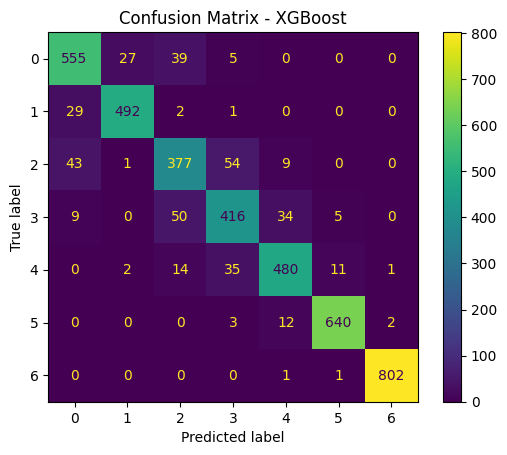

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

# Preprocess Custom Input Function
def preprocess_custom_input(custom_input):
    # Apply same mappings as in training data
    custom_input['Gender'] = {'Female': 0, 'Male': 1}[custom_input['Gender']]
    custom_input['SMOKE'] = {'no': 0, 'yes': 1}[custom_input['SMOKE']]
    custom_input['SCC'] = {'no': 0, 'yes': 1}[custom_input['SCC']]
    custom_input['CALC'] = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}[custom_input['CALC']]
    custom_input['FAVC'] = {'no': 0, 'yes': 1}[custom_input['FAVC']]
    custom_input['family_history_with_overweight'] = {'no': 0, 'yes': 1}[custom_input['family_history_with_overweight']]
    custom_input['CAEC'] = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}[custom_input['CAEC']]
    custom_input['MTRANS'] = {'Bike': 0, 'Walking': 1, 'Motorbike': 2, 'Public_Transportation': 3, 'Automobile': 4}[custom_input['MTRANS']]

    # Add derived features
    custom_input['bmi_category_encoded'] = calculate_bmi_category(custom_input)
    custom_input['age_faf'] = custom_input['Age'] * custom_input['FAF']
    custom_input['lifestyle_score'] = calculate_lifestyle_score(custom_input)
    custom_input['health_awareness_score'] = calculate_health_awareness_score(custom_input)
    return custom_input

# Function to calculate BMI category
def calculate_bmi_category(row):
    bmi = row['Weight'] / (row['Height'] ** 2)
    if bmi < 18.5:
        return 0  # Underweight
    elif 18.5 <= bmi < 25:
        return 1  # Healthy weight
    elif 25 <= bmi < 30:
        return 2  # Overweight
    elif 30 <= bmi < 35:
        return 3  # Obesity (Class 1)
    elif 35 <= bmi < 40:
        return 4  # Obesity (Class 2)
    else:
        return 5  # Obesity (Class 3)

# Function to calculate lifestyle score
def calculate_lifestyle_score(row):
    favc_score = row['FAVC']
    fcvc_score = row['FCVC']
    faf_score = row['FAF']
    tue_score = 1 if row['TUE'] > 2 else 0
    return favc_score - fcvc_score + tue_score - faf_score

# Function to calculate health awareness score
def calculate_health_awareness_score(row):
    scc_score = row['SCC']
    ch2o_score = row['CH2O']
    smoke_score = row['SMOKE']
    return scc_score + ch2o_score + smoke_score

# Example Custom Input
custom_input = {
    'Gender': 'Male',
    'Age': 25,
    'Height': 1.75,
    'Weight': 68,
    'family_history_with_overweight': 'yes',
    'FAVC': 'no',
    'FCVC': 2.0,
    'NCP': 3.0,
    'CAEC': 'Sometimes',
    'SMOKE': 'no',
    'CH2O': 1.0,
    'SCC': 'yes',
    'FAF': 0.5,
    'TUE': 0.5,
    'CALC': 'Sometimes',
    'MTRANS': 'Public_Transportation'
}

# Preprocess custom input
custom_input = preprocess_custom_input(custom_input)

# Create DataFrame and align feature order explicitly
custom_input_df = pd.DataFrame([custom_input], columns=X_train.columns)


# Scale custom input using only the numerical features the scaler was trained on
custom_input_scaled = scaler.transform(custom_input_df[numerical_featstrain])

# Evaluate XGBoost Model
xgb_test_preds = bst.predict(dval)
xgb_pred_labels = np.argmax(xgb_test_preds, axis=1)
xgb_accuracy = accuracy_score(y_val, xgb_pred_labels)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Confusion Matrix - XGBoost
cm_xgb = confusion_matrix(y_val, xgb_pred_labels)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=np.unique(y))
disp_xgb.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix - XGBoost")
plt.show()



LightGBM Accuracy: 0.9090


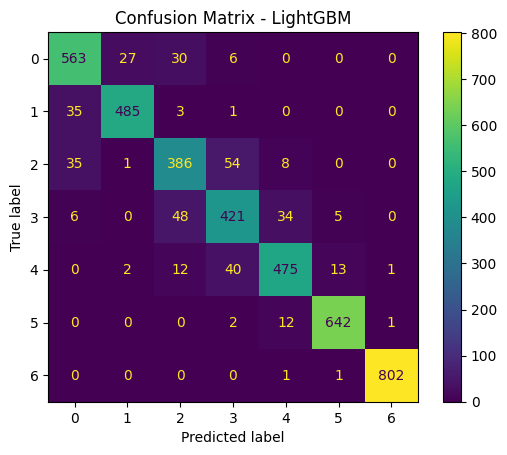


Ensemble Accuracy: 0.9097


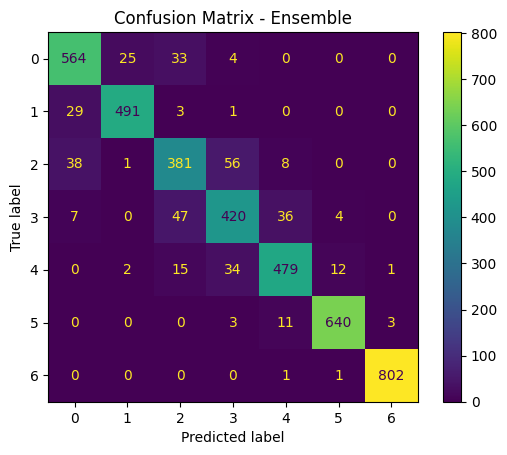

In [57]:
# 2. LightGBM
lgb_test_preds = lgb_bst.predict(X_val)  # Predictions on validation data
lgb_pred_labels = np.argmax(lgb_test_preds, axis=1)
lgb_accuracy = accuracy_score(y_val, lgb_pred_labels)
print(f"\nLightGBM Accuracy: {lgb_accuracy:.4f}")

# Confusion Matrix - LightGBM
cm_lgb = confusion_matrix(y_val, lgb_pred_labels)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=np.unique(y))
disp_lgb.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix - LightGBM")
plt.show()



# 3. Ensemble Model
ensemble_preds = (xgb_test_preds + lgb_test_preds) / 2  # Average predictions
ensemble_pred_labels = np.argmax(ensemble_preds, axis=1)
ensemble_accuracy = accuracy_score(y_val, ensemble_pred_labels)
print(f"\nEnsemble Accuracy: {ensemble_accuracy:.4f}")

# Confusion Matrix - Ensemble
cm_ensemble = confusion_matrix(y_val, ensemble_pred_labels)
disp_ensemble = ConfusionMatrixDisplay(confusion_matrix=cm_ensemble, display_labels=np.unique(y))
disp_ensemble.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix - Ensemble")
plt.show()



In [58]:
# XGBoost Prediction for Custom Input
# Create DataFrame with correct feature names
custom_input_df = pd.DataFrame([custom_input], columns=X_train.columns)

# Scale numerical features
custom_input_df[numerical_featstrain] = scaler.transform(custom_input_df[numerical_featstrain])

# Create DMatrix with feature names (converted to list of strings)
custom_xgb_dmatrix = xgb.DMatrix(custom_input_df, feature_names=list(X_train.columns))

# Prediction
custom_xgb_pred = np.argmax(bst.predict(custom_xgb_dmatrix), axis=1)[0]

print(f"\nXGBoost Prediction for Custom Input: {custom_xgb_pred}")


XGBoost Prediction for Custom Input: 0


In [66]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Example Custom Input
custom_input = {
    'Gender': 'Male',
    'Age': 50,
    'Height': 1.75,
    'Weight': 65,
    'family_history_with_overweight': 'yes',
    'FAVC': 'no',
    'FCVC': 2.0,
    'NCP': 3.0,
    'CAEC': 'Sometimes',
    'SMOKE': 'no',
    'CH2O': 1.0,
    'SCC': 'yes',
    'FAF': 0.5,
    'TUE': 0.5,
    'CALC': 'Sometimes',
    'MTRANS': 'Public_Transportation'
}

# Preprocess custom input
custom_input = preprocess_custom_input(custom_input)

# Create DataFrame and align feature order explicitly
custom_input_df = pd.DataFrame([custom_input], columns=X_train.columns)

# Scale numerical features
custom_input_df[numerical_featstrain] = scaler.transform(custom_input_df[numerical_featstrain])

# 1. XGBoost Prediction
custom_xgb_dmatrix = xgb.DMatrix(custom_input_df, feature_names=list(X_train.columns))
custom_xgb_pred = np.argmax(bst.predict(custom_xgb_dmatrix), axis=1)[0]
print(f"\nXGBoost Prediction for Custom Input: {custom_xgb_pred} ({label_map[custom_xgb_pred]})")

# 2. LightGBM Prediction
custom_lgb_pred = np.argmax(lgb_bst.predict(custom_input_df), axis=1)[0]
print(f"\nLightGBM Prediction for Custom Input: {custom_lgb_pred} ({label_map[custom_lgb_pred]})")

# 3. Ensemble Prediction
xgb_pred_prob = bst.predict(custom_xgb_dmatrix)  # Get probabilities from XGBoost
lgb_pred_prob = lgb_bst.predict(custom_input_df) # Get probabilities from LightGBM

ensemble_pred_prob = (xgb_pred_prob + lgb_pred_prob) / 2  # Average probabilities
ensemble_pred = np.argmax(ensemble_pred_prob, axis=1)[0]

print(f"\nEnsemble Prediction for Custom Input: {ensemble_pred} ({label_map[ensemble_pred]})")


XGBoost Prediction for Custom Input: 2 (Overweight_Level_I)

LightGBM Prediction for Custom Input: 2 (Overweight_Level_I)

Ensemble Prediction for Custom Input: 2 (Overweight_Level_I)


In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 1. XGBoost
xgb_test_preds = bst.predict(dval)  # Predictions on validation data
xgb_pred_labels = np.argmax(xgb_test_preds, axis=1)
xgb_accuracy = accuracy_score(y_val, xgb_pred_labels)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Calculate and print precision, recall, and F1 score for XGBoost
xgb_precision = precision_score(y_val, xgb_pred_labels, average='weighted')
xgb_recall = recall_score(y_val, xgb_pred_labels, average='weighted')
xgb_f1 = f1_score(y_val, xgb_pred_labels, average='weighted')
print(f"XGBoost Precision: {xgb_precision:.4f}")
print(f"XGBoost Recall: {xgb_recall:.4f}")
print(f"XGBoost F1 Score: {xgb_f1:.4f}")


# 2. LightGBM
lgb_test_preds = lgb_bst.predict(X_val)  # Predictions on validation data
lgb_pred_labels = np.argmax(lgb_test_preds, axis=1)
lgb_accuracy = accuracy_score(y_val, lgb_pred_labels)
print(f"\nLightGBM Accuracy: {lgb_accuracy:.4f}")

# Calculate and print precision, recall, and F1 score for LightGBM
lgb_precision = precision_score(y_val, lgb_pred_labels, average='weighted')
lgb_recall = recall_score(y_val, lgb_pred_labels, average='weighted')
lgb_f1 = f1_score(y_val, lgb_pred_labels, average='weighted')
print(f"LightGBM Precision: {lgb_precision:.4f}")
print(f"LightGBM Recall: {lgb_recall:.4f}")
print(f"LightGBM F1 Score: {lgb_f1:.4f}")

XGBoost Accuracy: 0.9061
XGBoost Precision: 0.9061
XGBoost Recall: 0.9061
XGBoost F1 Score: 0.9061

LightGBM Accuracy: 0.9090
LightGBM Precision: 0.9091
LightGBM Recall: 0.9090
LightGBM F1 Score: 0.9090


In [61]:
import pickle

# Save XGBoost model
with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(bst, file)

# Save LightGBM model
with open('lgb_model.pkl', 'wb') as file:
    pickle.dump(lgb_bst, file)


Accuracy: 0.8460982658959537
Precision: 0.8470661790164818
Recall: 0.8460982658959537
F1-score: 0.8465002775738648


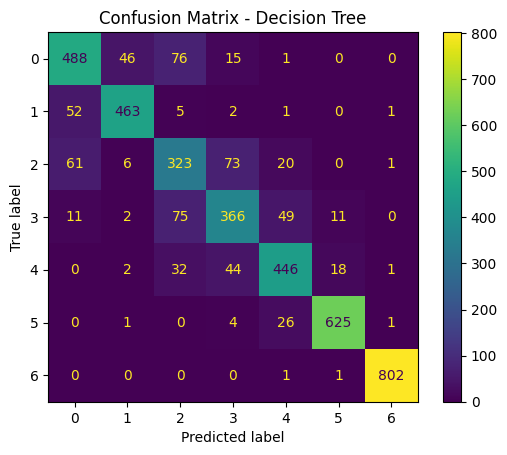

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Make predictions
y_pred = tree_model.predict(X_test)

# Evaluate the model
tree_accuracy = accuracy_score(y_test, y_pred)
tree_precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
tree_recall = recall_score(y_test, y_pred, average='weighted')      # Use 'weighted' for multi-class
tree_f1 = f1_score(y_test, y_pred, average='weighted')            # Use 'weighted' for multi-class


print(f"Accuracy: {tree_accuracy}")
print(f"Precision: {tree_precision}")
print(f"Recall: {tree_recall}")
print(f"F1-score: {tree_f1}")


# Create and display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='viridis', values_format='d')
plt.title("Confusion Matrix - Decision Tree")
plt.show()

In [63]:
print(f"XGBoost Accuracy: {xgb_accuracy}")
print(f"LightGBM Accuracy: {lgb_accuracy}")
print(f"Decision Tree Accuracy: {tree_accuracy}")
print(f"Ensemble Accuracy: {ensemble_accuracy}")

# 7. Identify the best model
best_model = max([("XGBoost", xgb_accuracy), ("LightGBM", lgb_accuracy), ("Decision Tree", tree_accuracy), ("Ensemble", ensemble_accuracy)], key=lambda item: item[1])[0]

print(f"\nThe best model is: {best_model}")

XGBoost Accuracy: 0.9060693641618497
LightGBM Accuracy: 0.9089595375722543
Decision Tree Accuracy: 0.8460982658959537
Ensemble Accuracy: 0.9096820809248555

The best model is: Ensemble


In [64]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb  # Assuming you want to test XGBoost feature importance

# Assuming X and y are your feature and target data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your XGBoost model (replace with your actual model training code)
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Function to perform permutation test for a single feature
def permutation_importance(model, X_test, y_test, feature):
    original_score = accuracy_score(y_test, model.predict(X_test))
    permuted_scores = []
    for _ in range(1000):  # Number of permutations
        X_permuted = X_test.copy()
        X_permuted[feature] = np.random.permutation(X_permuted[feature])
        permuted_score = accuracy_score(y_test, model.predict(X_permuted))
        permuted_scores.append(permuted_score)
    importance = original_score - np.mean(permuted_scores)
    return importance

# Calculate permutation importance for all features
feature_importances = {}
for feature in X_train.columns:
    importance = permutation_importance(model, X_test, y_test, feature)
    feature_importances[feature] = importance

# Print feature importances
sorted_importances = sorted(feature_importances.items(), key=lambda item: item[1], reverse=True)
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

Weight: 0.4980086705202312
FCVC: 0.1242909441233142
Gender: 0.1152791425818882
bmi_category_encoded: 0.044561657032755275
Height: 0.03014812138728329
Age: 0.02354696531791911
TUE: 0.011256021194605004
CH2O: 0.009735308285163669
CALC: 0.0064826589595374795
family_history_with_overweight: 0.005569845857418154
NCP: 0.005053227360308221
FAF: 0.004632947976878521
SCC: 0.0032369942196530666
FAVC: 0.003111994219653247
CAEC: 0.00304744701348747
health_awareness_score: 0.0025816473988440336
age_faf: 0.0013379094412331316
MTRANS: 0.0012398843930636616
lifestyle_score: 0.0009089595375721959
SMOKE: 0.0002550578034683504


Key Takeaways:

Top Features: Weight, FCVC, Gender, and BMI categories drive predictions.

Less Impactful: Smoking status, transportation habits (MTRANS), and engineered scores (age_faf, lifestyle_score) contribute minimally.

Actionable Insight: Focus on weight management and dietary habits (e.g., vegetable intake) for obesity risk interventions.